## Civitta default ML model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from civitta.data_loader import DataLoader

df_raw = DataLoader().load()
df_raw.head()

,clientid,client_type,ratio,loan_type,loan_initial_term,loan_initial_amount,loan_to_value_ratio,annual_percentage_rate,monthly_interest_rate,region,branch,client_gender,income,vehicle_production_year,vehicle_initial_assessment_value,age,had_car_loan,had_other_loans
0,0,default,1.166667,leaseback,36,1920,0.200000,35.875763,3.374,region 9,branch 3,male,1214,2002,9600,37.0,0,0
1,1,default,1.027778,leaseback,54,5040,0.777778,36.079749,3.374,NaN,branch 3,male,0,1995,6480,36.0,0,0
2,2,default,0.916667,leasing,18,2400,0.454545,42.292028,3.374,region 2,branch 5,male,720,1999,5280,57.0,0,0
3,3,default,0.916667,leaseback,36,9360,0.886364,35.580055,3.374,NaN,branch 3,female,0,2000,10560,65.0,0,0
4,4,default,0.888889,leasing,54,5760,0.750000,37.090166,3.374,region 6,branch 2,male,0,2008,7680,35.0,0,0


Displaying meta information about dataset: column data types, null values, numer of samples and RAM memory usage.

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10970 entries, 0 to 10969
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   clientid                          10970 non-null  int64  
 1   client_type                       10970 non-null  object 
 2   ratio                             8389 non-null   float64
 3   loan_type                         10970 non-null  object 
 4   loan_initial_term                 10970 non-null  int64  
 5   loan_initial_amount               10970 non-null  int64  
 6   loan_to_value_ratio               10970 non-null  float64
 7   annual_percentage_rate            10970 non-null  float64
 8   monthly_interest_rate             10970 non-null  float64
 9   region                            9880 non-null   object 
 10  branch                            10970 non-null  object 
 11  client_gender                     10970 non-null  object 
 12  inco

I split features into numerical, nominal and ordinal.

I didn't take clientid column, because it's a technical primary key column from a database. This column was helpful to join 3 tables each other, but for ML modelling is useless, because It didn't give any additional information.

In [4]:
numerical_features = [
    "ratio", "loan_initial_term", "loan_initial_amount", 
    "loan_to_value_ratio", "annual_percentage_rate", "monthly_interest_rate",
    "income", "vehicle_production_year", "vehicle_initial_assessment_value", "age"
    ]
nominal_features = [
    "loan_type", "region", 
    "branch", "client_gender"
    ]
ordinal_features = [
    "had_car_loan", "had_other_loans"
]

target = "client_type"

In [5]:
df_raw.isna().sum()

clientid                               0
client_type                            0
ratio                               2581
loan_type                              0
loan_initial_term                      0
loan_initial_amount                    0
loan_to_value_ratio                    0
annual_percentage_rate                 0
monthly_interest_rate                  0
region                              1090
branch                                 0
client_gender                          0
income                                 0
vehicle_production_year                0
vehicle_initial_assessment_value       0
age                                   22
had_car_loan                           0
had_other_loans                        0
dtype: int64

Applied pipelines from civitta module. Pipelines set imputer(most frequent or mean strategy) and then encode it using OrdinalEncoder, OneHotEncoder for nominal features like client_type or loan type and StandardScaler for numerical features.


Why I choose "dummy" imputing most frequent/mean values? 

Because base on CRISP-ML process loop this imputation gave the best results. Suprisingly LightGBM and Decision Tree models gave worse results. 
Of course I could stay with missing data when I am using tree models, because the are resistant for null values. What is more I could drop null values, but ratio has 2581 null values, which is 23% of samples in a dataset. Using removing rows with null values we also remove samples with minority class of default loan.

Also I tried to mix imputations like: droping nulls in age column, imputed most frequent values or imputing using miceforest package(https://github.com/AnotherSamWilson/miceForest).

After many experiments I stay to impute constants, with a awarness of distorting distribution for null features.

We may also think about not using columns like ratio, age or region in training of the model, but ratio hase vast impact and explainability of the client_type target variable. Age and region has lower impact, but they were used in model.

In [6]:
from civitta.transform_pipeline import TransformationPipeline

df = df_raw.copy()
transform_pipe = TransformationPipeline()

# nominal data
nominal_data = transform_pipe.nominal_pipeline.fit_transform(df[nominal_features])
nominal_columns = transform_pipe.nominal_pipeline.get_feature_names_out()
X_nominal = pd.DataFrame(nominal_data, columns=nominal_columns)

# ordinal data
X_ordinal = df[ordinal_features]

# numerical data
numerical_data = transform_pipe.numerical_pipeline.fit_transform(df[numerical_features])
numerical_columns = transform_pipe.numerical_pipeline.get_feature_names_out()
X_numerical = pd.DataFrame(numerical_data, columns=numerical_columns)

In [7]:
X = pd.concat([X_numerical, X_nominal, X_ordinal], axis=1)

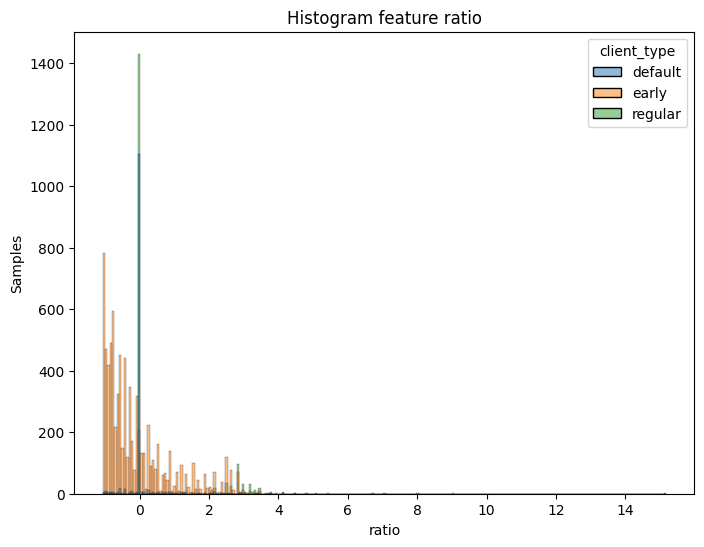

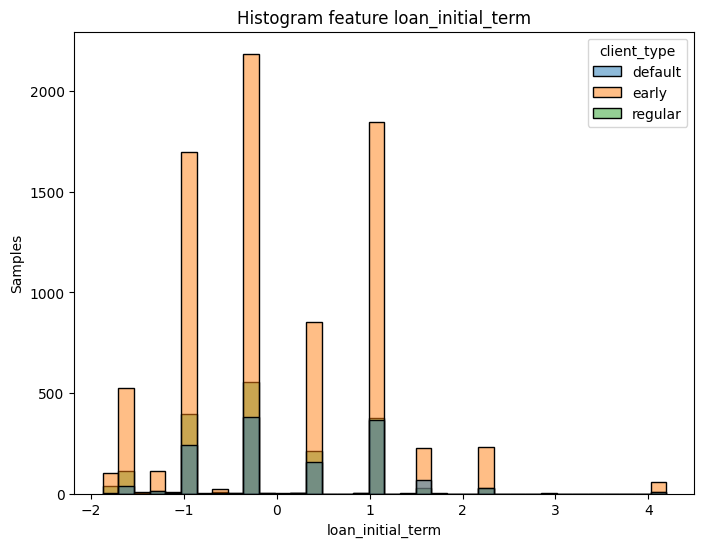

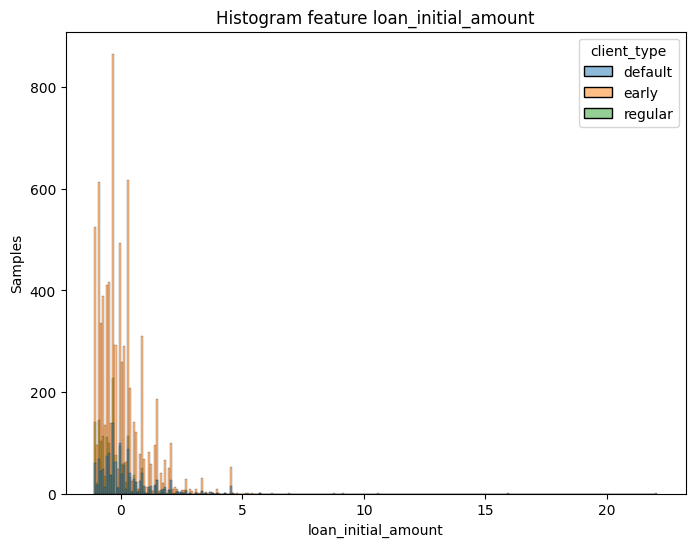

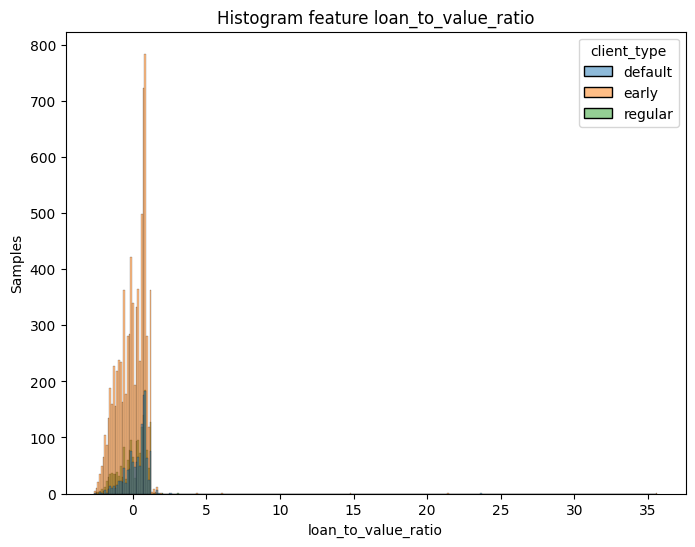

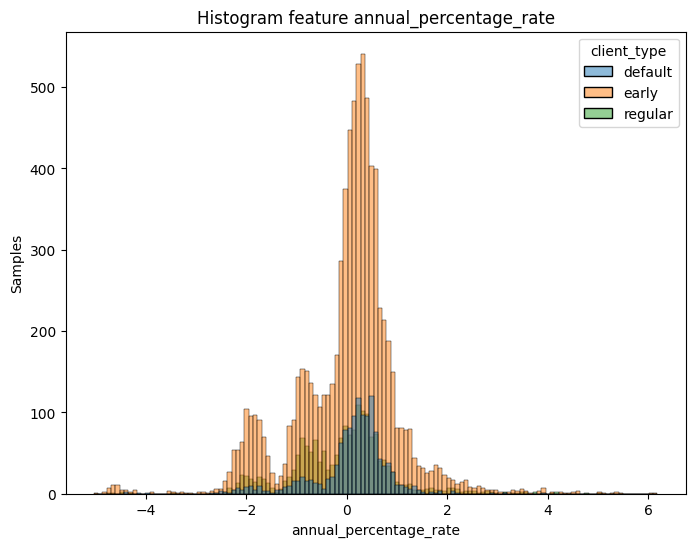

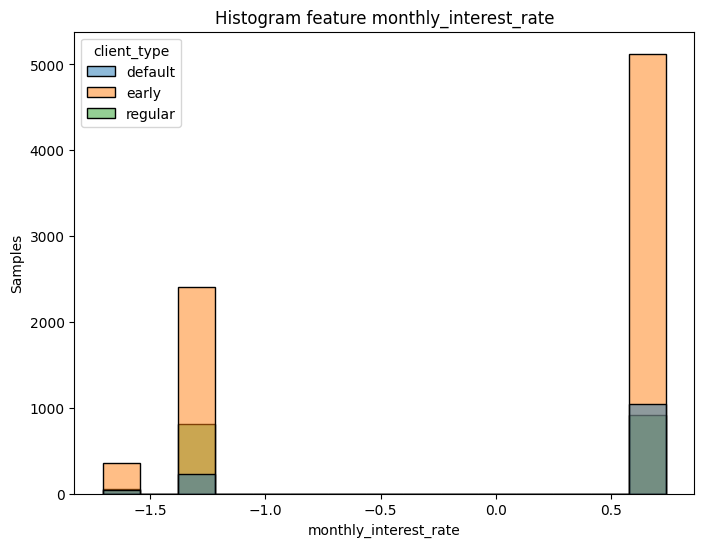

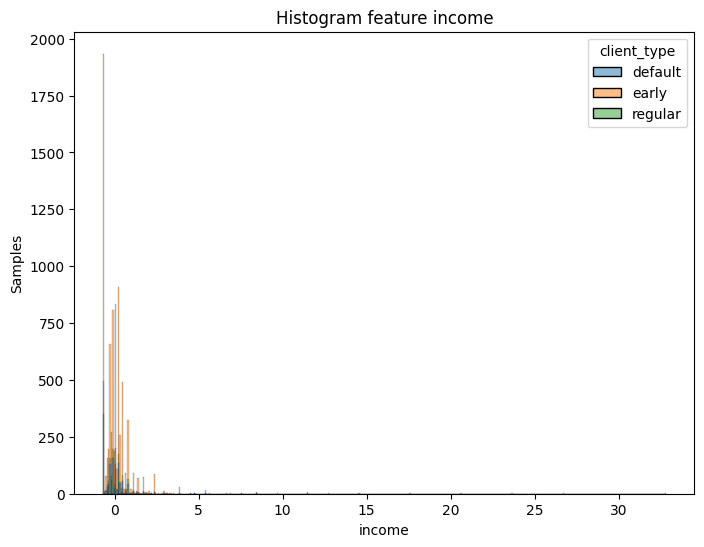

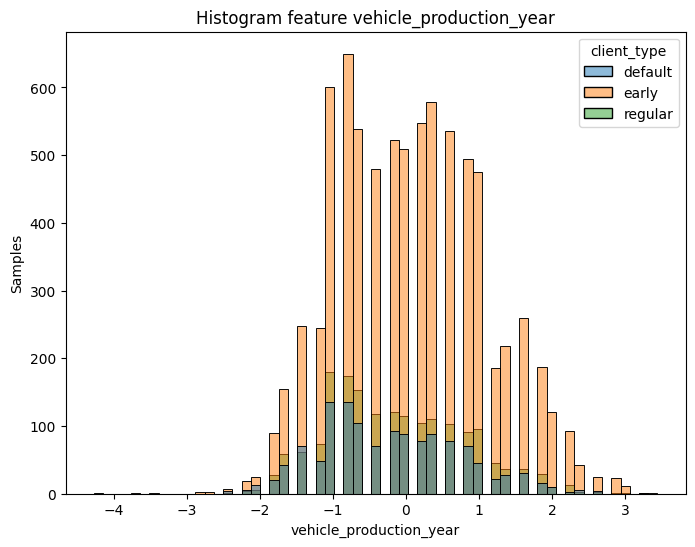

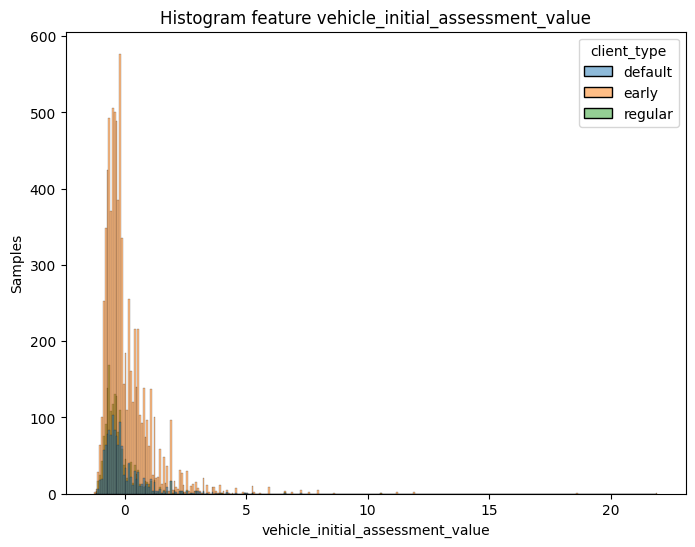

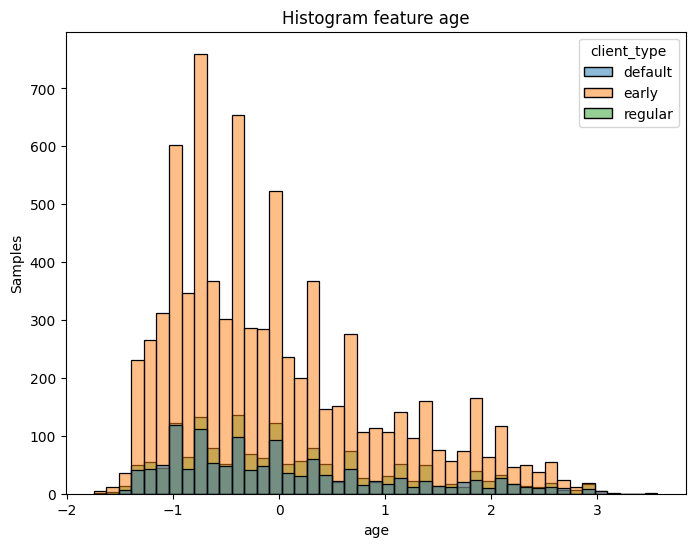

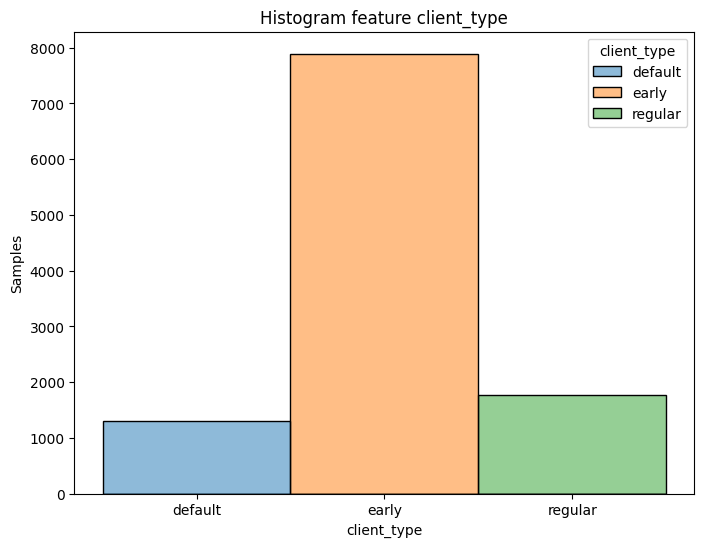

In [8]:
df_plotting_transformed = pd.concat([X_numerical, df["client_type"]], axis=1)

for column in df_plotting_transformed.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df_plotting_transformed, x=column, hue="client_type")
    plt.title(f'Histogram feature {column}')
    plt.xlabel(column)
    plt.ylabel('Samples')
    plt.show()

#### Checking outliers

After scalling features we may look at outliers using box plot charts. Using this method we can see that "probably" all of the dots above 5 are outliers.

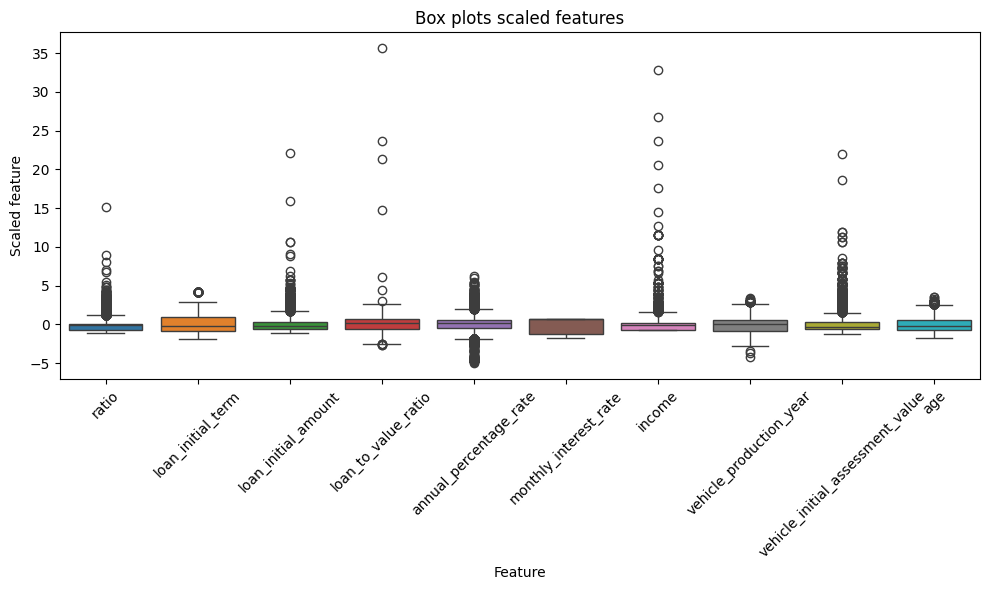

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=X.iloc[:, :10])
plt.title('Box plots scaled features')
plt.xlabel('Feature')
plt.ylabel('Scaled feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
possible_outliers = X[X.values > 5].index

df_raw.iloc[possible_outliers, :]

,clientid,client_type,ratio,loan_type,loan_initial_term,loan_initial_amount,loan_to_value_ratio,annual_percentage_rate,monthly_interest_rate,region,branch,client_gender,income,vehicle_production_year,vehicle_initial_assessment_value,age,had_car_loan,had_other_loans
7,7,default,0.833333,leaseback,18,12960,0.794118,41.083697,3.3740,region 5,branch 5,male,19200,2009,16320,36.0,0,0
22,22,default,0.666667,leaseback,18,2880,0.061856,41.105422,3.3740,region 6,branch 3,female,1200,2010,46560,68.0,0,0
86,86,default,0.333333,leaseback,54,24000,0.384615,36.984371,3.3740,region 8,branch 3,female,4800,2003,62400,29.0,0,0
105,105,default,0.266667,leaseback,90,28800,1.200000,36.160576,3.3740,region 6,branch 3,male,4800,2011,24000,42.0,0,0
172,172,default,0.116667,leaseback,90,14400,0.750000,35.955938,3.3740,region 6,branch 6,male,14400,2010,19200,31.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10442,10442,regular,NaN,leaseback,54,69120,0.800000,21.481099,2.5305,region 2,branch 6,male,14400,2018,86400,31.0,0,0
10578,10578,regular,NaN,leaseback,90,13920,0.783784,28.373569,2.5305,region 6,branch 6,male,14400,2010,17760,31.0,1,0
10626,10626,regular,NaN,leaseback,72,6240,0.866667,37.244154,3.3740,region 8,branch 5,male,9600,2003,7200,45.0,0,0
10678,10678,regular,NaN,leaseback,54,4608,0.080000,36.400498,3.3740,region 10,branch 1,male,0,1998,57600,55.0,1,0


Using elbow method we can see that, where number of clusters is optimal. In our case we have 3 classes: early, default and regular. In the plot we cannot see significant break (like elbow).

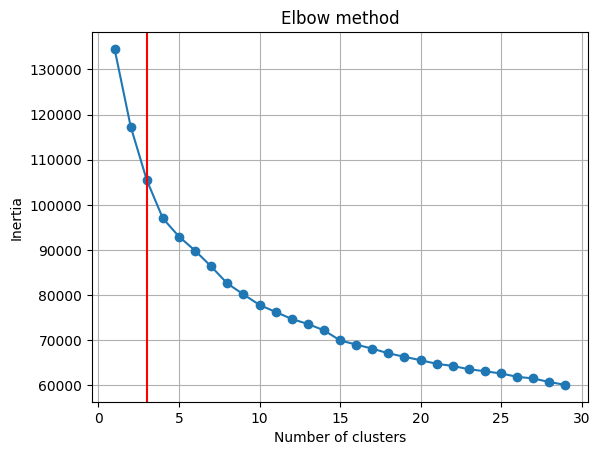

In [17]:
from sklearn.cluster import KMeans

max_clusters = 30
clusters = range(1, max_clusters)
# elbow method
inertia = []
for k in clusters:
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(clusters, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.axvline(3, color="red")
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.grid()
plt.show()

Futhermore, I calculate KMeans model to generate 3 clusters to check if our X explained good every cluster and we see that is quite far from good results, where kmeans_cluster should cover most of the samples, but it's splitted almost for equal parts.

There is albo possible that KMeans failed so bad, because this method is best for spherical shapes of cluster in the space.

In [18]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['client_type_encoded'] = le.fit_transform(df['client_type'])

kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(X)
df['kmeans_cluster'] = kmeans.predict(X)
df['kmeans_cluster'] = df['kmeans_cluster'].map({0: "default", 1: "early", 2: "regular"})


df_kmeans = pd.concat([df['client_type'], df['kmeans_cluster']], axis=1)
df_kmeans

,client_type,kmeans_cluster
0,default,regular
1,default,regular
2,default,regular
3,default,regular
4,default,regular
...,...,...
10965,regular,early
10966,regular,regular
10967,regular,regular
10968,regular,regular


In [14]:
le.classes_

array(['default', 'early', 'regular'], dtype=object)

In [19]:
df_kmeans.value_counts(['client_type', 'kmeans_cluster'], sort=False)

client_type  kmeans_cluster
default      default            213
             early              218
             regular            876
early        default           2130
             early             1414
             regular           4348
regular      default            744
             early              165
             regular            862
Name: count, dtype: int64

Labels after prediction they are not giving the same results, as they were labeled in dataset.

#### Detect and remove outliers using Isolation Forest

I used Isolation Forest to detect outliers, which may have impact into final model. When I made histograms/box plots for every variable I saw there are features, where outliers are. What is interesting is fact that model didn't classify as an outlier values after rescaling greater than 10.

number of samples(1) and outliers (-1): Counter({1: 10276, -1: 694})


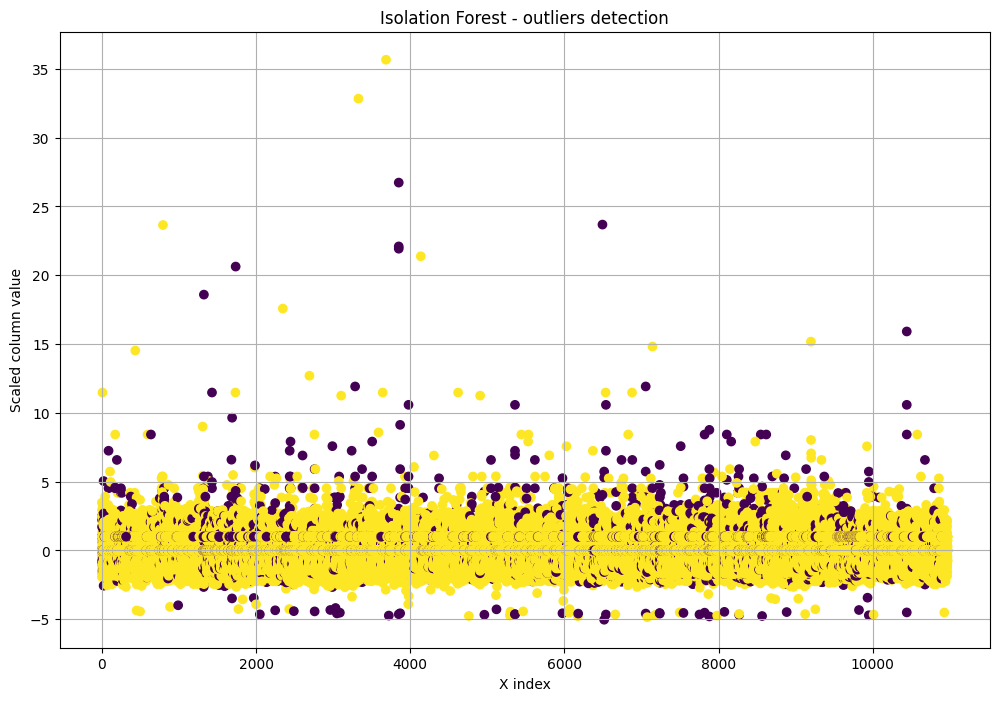

In [20]:
from sklearn.ensemble import IsolationForest
from collections import Counter


if_clf = IsolationForest(random_state=123)
if_clf.fit(X)

outliers_preds = if_clf.predict(X)

print(f"number of samples(1) and outliers (-1): {Counter(outliers_preds)}")

plt.figure(figsize=(12, 8))
for column in X.columns:
    plt.scatter(
        range(len(X)), 
        X[column], 
        c=outliers_preds, 
        cmap="viridis"
    )

plt.title("Isolation Forest - outliers detection")
plt.xlabel("X index")
plt.ylabel("Scaled column value")
plt.grid()
plt.show()

In [21]:
# let's remove outliers

outliers_index = np.where(outliers_preds == -1)[0]
len(outliers_index)

694

I give "default" flag 1 and "regular" & "early" clients flag 0.  

In [22]:
X_ready = X[~X.index.isin(outliers_index)] \
            .reset_index(drop=True)
y_ready = df[~df.index.isin(outliers_index)] \
            .reset_index(drop=True) \
            ["client_type"].apply(lambda x: 1 if x == "default" else 0)

#### Testing using chi2



In [24]:
from scipy.stats import chi2_contingency

for var in X_ready.select_dtypes("float64").columns:
    contingency_table = pd.crosstab(X_ready[var], y_ready)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square test for variable {var} and client_type:")
    print(f"Chi-square statistic: {chi2}")
    print(f"p-value: {p}")

Chi-square test for variable ratio and client_type:
Chi-square statistic: 2906.362056384934
p-value: 0.0
Chi-square test for variable loan_initial_term and client_type:
Chi-square statistic: 91.71356433881694
p-value: 6.447497608066037e-08
Chi-square test for variable loan_initial_amount and client_type:
Chi-square statistic: 281.4020137462122
p-value: 0.0007251200451183113
Chi-square test for variable loan_to_value_ratio and client_type:
Chi-square statistic: 1019.0319109698498
p-value: 0.8508003348461866
Chi-square test for variable annual_percentage_rate and client_type:
Chi-square statistic: 6464.469956888493
p-value: 0.9795501780722983
Chi-square test for variable monthly_interest_rate and client_type:
Chi-square statistic: 138.79101015574096
p-value: 7.276375045912801e-31
Chi-square test for variable income and client_type:
Chi-square statistic: 352.81366231102515
p-value: 0.6803371131368395
Chi-square test for variable vehicle_production_year and client_type:
Chi-square statisti

Based on the chi square test and significance level equals alpha=0.05. We should remove from X variables: loan_to_value_ratio, annual_percentage_rate, income, vehicle_initial_assessment_value, age

In [94]:
X_ready.drop(
    columns=["loan_to_value_ratio", "annual_percentage_rate", "income", "vehicle_initial_assessment_value", "age"], 
    inplace=True
)

We have to split at least two parts training(80% samples) and test(20% samples) dataset. We have small amount of data so I will not add validation dataset. The most important at this part is that training dataset must have more samples than test sets.

In [39]:
from sklearn.model_selection import train_test_split

seed = 123
X_train, X_test, y_train, y_test = train_test_split(
    X_ready, y_ready, random_state=seed, train_size=0.8
)

X_train.shape, X_test.shape

((8220, 30), (2056, 30))

### Rebalancing dataset
We have to balance dataset, because "default" is a minority class. 

In [41]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=seed)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

Counter(y_train_rus)

Counter({0: 978, 1: 978})

In [42]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=seed)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
y_train_ros.value_counts()

client_type
0    7242
1    7242
Name: count, dtype: int64

In [43]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = seed)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
y_train_smote.value_counts()

client_type
0    7242
1    7242
Name: count, dtype: int64

In [44]:
from imblearn.under_sampling import NearMiss 
nr = NearMiss()

X_train_miss, y_train_miss = nr.fit_resample(X_train, y_train)
y_train_miss.value_counts()

client_type
0    978
1    978
Name: count, dtype: int64

For our need I am going to use UnderSamplingMethod, because we will not adding new estimator to dataset.

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

rf_clf = RandomForestClassifier(random_state=seed,
                               n_estimators=1000,
                                max_depth=7)
rf_clf.fit(X_train_rus, y_train_rus)
rf_preds = rf_clf.predict(X_test)

print(classification_report(y_test, rf_preds))
print("confusion matrix")
print(confusion_matrix(y_test, rf_preds))
print(f"roc_auc_score: {roc_auc_score(y_test, rf_preds)}")

              precision    recall  f1-score   support

           0       0.97      0.78      0.87      1798
           1       0.36      0.86      0.50       258

    accuracy                           0.79      2056
   macro avg       0.67      0.82      0.68      2056
weighted avg       0.90      0.79      0.82      2056

confusion matrix
[[1399  399]
 [  37  221]]
roc_auc_score: 0.8173379551784498


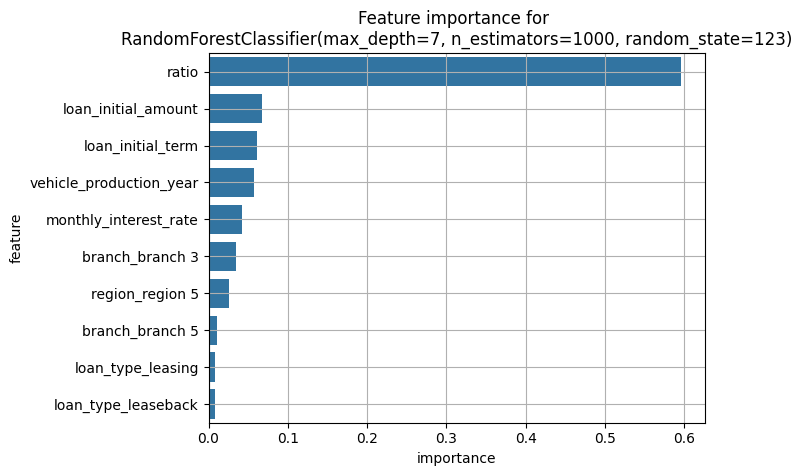

In [93]:
def display_feature_importance(clf):
    df_importance = pd.DataFrame(
        {"feature": clf.feature_names_in_, 
        "importance": clf.feature_importances_}
    ).sort_values("importance", ascending=False).iloc[:10, :]
    sns.barplot(data=df_importance, x="importance", y="feature")
    plt.title(f"Feature importance for \n{clf}")
    plt.grid()

display_feature_importance(rf_clf)

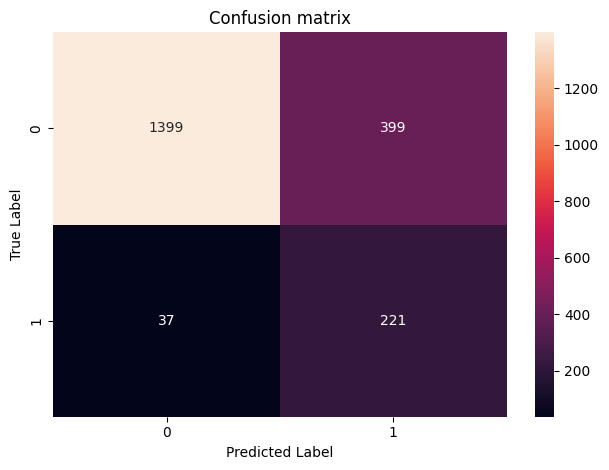

In [102]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.title("Confusion matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, rf_preds)

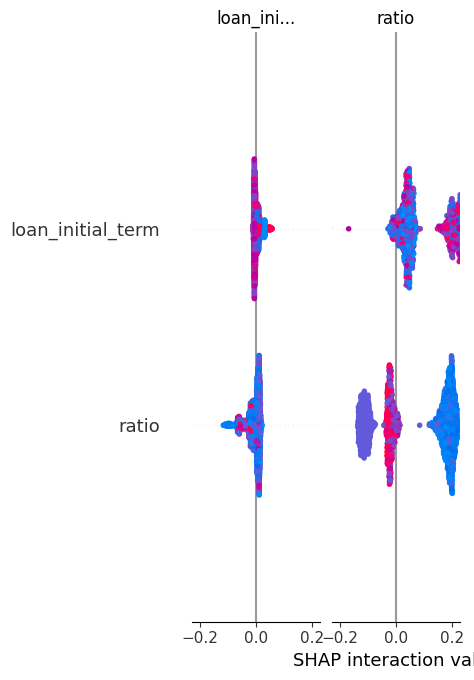

In [33]:
import shap

explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_size=(20, 20))
plt.show()

### XGBoost

In [78]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(n_estimators=1000, max_depth=7, objective="binary:logistic", random_state=seed)
xgb_clf.fit(X_train_rus, y_train_rus)
xgb_preds = xgb_clf.predict(X_test)

print(classification_report(y_test, xgb_preds))
print("confusion matrix")
print(confusion_matrix(y_test, xgb_preds))
print(f"roc_auc_score: {roc_auc_score(y_test, xgb_preds)}")

              precision    recall  f1-score   support

           0       0.97      0.83      0.89      1798
           1       0.40      0.81      0.54       258

    accuracy                           0.82      2056
   macro avg       0.68      0.82      0.71      2056
weighted avg       0.90      0.82      0.85      2056

confusion matrix
[[1484  314]
 [  48  210]]
roc_auc_score: 0.8196575005820421


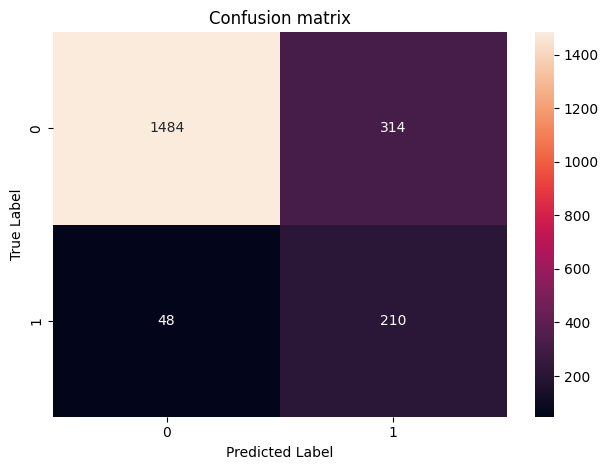

In [97]:
plot_confusion_matrix(y_test, xgb_preds)

We classify: TP=210 samples

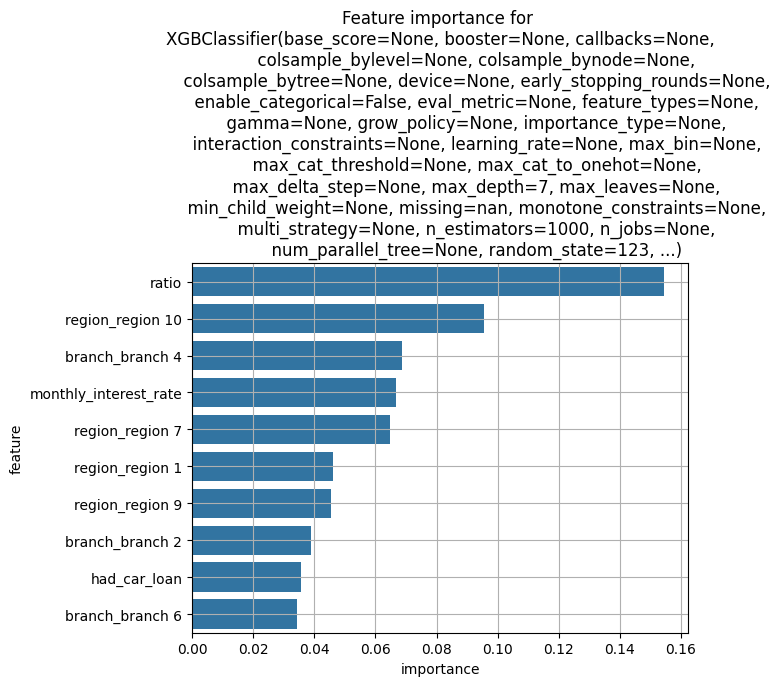

In [92]:
display_feature_importance(xgb_clf)

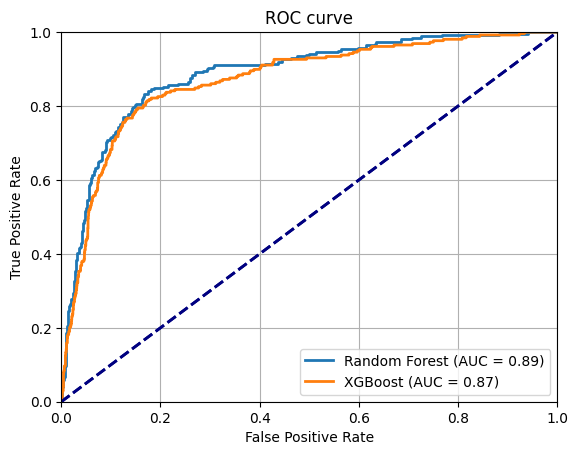

In [101]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(fpr, tpr, name):
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.grid(visible=True)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")


clfs = [(rf_clf, "Random Forest"), (xgb_clf, "XGBoost")]
for clf, name in clfs:
    proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, proba)
    plot_roc_curve(fpr, tpr, name)

### Conclusions



Random Forest and XGBoosting models, when we compare them in ROC curve, they perform quite similar.